In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
plt.rcParams.update({'font.size': 16})
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [2]:
nn_depth  = [4]
nn_width  = [256]
batchSize =  256
option3a  = True
option3b  = False
option4   = False
trec     = 1

In [3]:
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

#quantiles = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.5, 0.55, 0.65, 0.75, 0.85, 0.95])
quantiles = np.array([0.03, 0.16, 0.5, 0.84,  0.97])
quantiles = np.array([0.002, 0.03, 0.16, 0.5, 0.84, 0.97, 0.998])

In [4]:
from torch.utils.data import DataLoader, random_split
from aws_general import awsData

In [5]:
#for i, batch in enumerate(validation_data):
#        print(i, batch[0].shape)

### evaluate neural-net size

In [6]:
#for channel in ['C32','C33','C34', 'C35', 'C36']:
for channel in ["C32"]:
    print ('doing channel: ', channel)
    if option4:
        inChannels = [channel, 'C41', 'C42', 'C43', 'C44']
        data = awsData("/home/inderpreet/Dendrite/Projects/AWS-325GHz/TB_AWS/TB_AWS_m60_p60_four.nc", 
                       inChannels, option = 4, T_rec = trec,
                      batch_size = batchSize)   
        inputs = 5
    
    if option3b:
        inChannels = [channel, 'C41', 'C42', 'C43']
        data = awsData("/home/inderpreet/Dendrite/Projects/AWS-325GHz/TB_AWS/TB_AWS_m60_p60_three_b.nc",
                   inChannels, option = "3b", T_rec = trec,
                  batch_size = batchSize)  
        inputs = 4
        
    if option3a:
#        inChannels = [channel, 'C41', 'C42', 'C43']
        inChannels = [channel, "C4X"]
        data = awsData("/home/inderpreet/Dendrite/Projects/AWS-325GHz/TB_AWS/TB_AWS_m60_p60_three_a.nc",
                       inChannels, option = "3a", T_rec = trec,
                  batch_size = batchSize)
        inputs = 2   
    
    n = len(data)
    n_train = int(0.9 * n)
    n_val = n - n_train
    training_data, validation_data = random_split(data, [n_train, n_val])
    
    for nn_dep in nn_depth:
        for nn_wid in nn_width:
            qrnn = QRNN(inputs, quantiles, (nn_dep, nn_wid , "relu"))
            for lr in [0.01, 0.001, 0.0001]:
                print ("NEW LEARNING RATE")
                qrnn.train(
                    training_data,
                    validation_data,
                    batch_size=batchSize,
                    momentum = 0,
                    sigma_noise=None,
                    initial_learning_rate= lr ,
                    maximum_epochs=20,
                    convergence_epochs= 2,    
                    gpu=True)

            if option3a:    
                filename = "option3a_qrnn_models_3sigma/qrnn_%s_%s_%s_4X.nc" % (str(nn_dep), str(nn_wid), str(inChannels[0]))
            if option3b:    
                filename = "option3b_qrnn_models_3sigma_Trec%s/qrnn_%s_%s_%s.nc" % (str(trec), str(nn_dep), str(nn_wid), str(inChannels[0]))
            if option4:
                filename = "option4_qrnn_models_3sigma_Trec%s/qrnn_%s_%s_%s.nc" %  (str(trec), str(nn_dep), str(nn_wid), str(inChannels[0]))
            qrnn.save(filename)

doing channel:  C32
[2, 7]
NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE


Text(0, 0.5, 'Observed frequency')

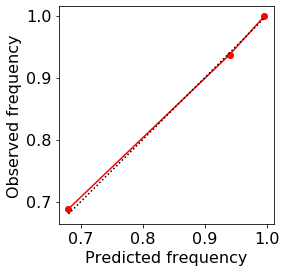

In [7]:
#filename = "option4_qrnn_models/qrnn_%s_%s_%s.nc" % (str(nn_depth), str(128), str(inChannels[0]))
#print(filename)
#qrnn = QRNN.load(filename)
x, y = qrnn.calibration(validation_data)
f, ax = plt.subplots(1, 1)
ax.plot(x, y, marker = "o", c = 'r')
ax.plot(x, x, ls = ":", c = "k")
#ax.set_xlim([0.1, 0.9])
#ax.set_ylim([0.1, 0.9])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")


In [8]:
y_pre = []
y = []
y_prior = []
y_pos_mean = []
x_in = []

nbatch = validation_data.__len__()
print (nbatch)
for i in range(nbatch):
    
    xx, yy = validation_data.__getitem__(i)
    
    x = xx.detach().numpy() 

    y_prior.append((x * data.std) + data.mean)
#    y_prior.append((x[:, 0]))

    y_pre.append(qrnn.predict(x)) 
    y_pos_mean.append((qrnn.posterior_mean(x)))
       
    y.append(yy.detach().numpy())
    x_in.append(x)

50


In [9]:
x_in = np.concatenate(x_in, axis = 0)
y_pre = np.concatenate(y_pre, axis = 0)
y = np.concatenate(y, axis= 0)
y_prior = np.concatenate(y_prior, axis = 0)
y_pos_mean = np.concatenate(y_pos_mean, axis = 0)

dtb_max_meas = 15

im = np.abs(y_prior[:, 1] - y_prior[:, 0]) <= dtb_max_meas 


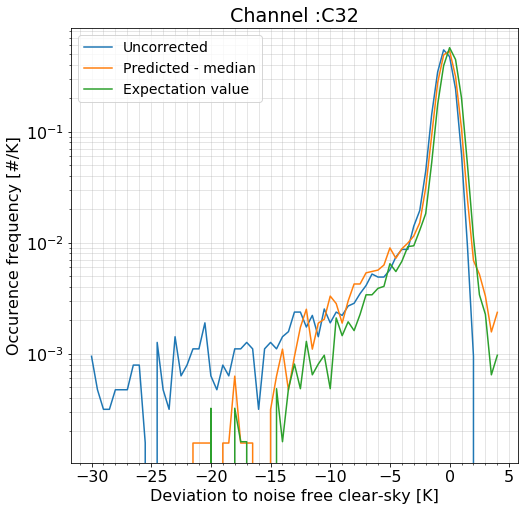

In [10]:
dtb_pre = y_pre[:, 3] - y
dtb_prior = y_prior[:, 0] - y
dtb_pos_mean = y_pos_mean - y
binstep = 0.5
bins = np.arange(-30, 5, binstep)
hist_pre = np.histogram(dtb_pre, bins, density = True)
hist_prior = np.histogram(dtb_prior, bins, density = True)
hist_pos_mean = np.histogram(dtb_pos_mean[im], bins, density = True)


fig, ax = plt.subplots(1,1, figsize = [8,8])
ax.plot(bins[:-1], hist_prior[0])
ax.plot(bins[:-1], hist_pre[0])
ax.plot(bins[:-1], hist_pos_mean[0])

ax.set_yscale('log')
ax.set_ylabel('Occurence frequency [#/K]')
ax.set_xlabel('Deviation to noise free clear-sky [K]')
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.4)
ax.set_title("Channel :%s"%inChannels[0])
ax.legend(["Uncorrected", "Predicted - median", "Expectation value"], prop={'size': 14})
fig.savefig('Channel_%s'%inChannels[0])

In [11]:
y_crps = qrnn.crps(y_pre, y, quantiles)
print (y_crps.min(), y_crps.max())
y_crps.shape

0.25916133331298835 9.842466163330078


(12800,)

(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.14141165e+01, 6.58728200e+00,
        1.17226061e-01, 1.85093781e-02, 1.85093781e-02, 2.05659756e-03,
        2.05659756e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 8.80223758e-01, 1.43961830e+00,
        3.47564988e-01, 2.81753866e-01, 2.07716354e-01, 4.11319513e-03,
        2.05659756e-03, 8.22639026e-03, 0.00000000e+00, 2.05659756e-03,
        0.00000000e+00, 2.05659756e-03, 4.11319513e-02, 8.22639026e-02,
        2.26225732e-02, 2.87923659e-02, 2.26225732e-02, 1.64527805e-02,
        1.23395854e-02, 8.22639026e-03, 1.43961830e-02, 4.11319513e-03,
        1.02829878e-02, 2.26225732e-02, 1.31622244e+00, 1.43344850e+00,
        4.66847647e-01, 9.25468904e-02, 2.67357683e-02, 2.67357683e-02,
        8.22639026e-03, 8.22639026e-03]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 

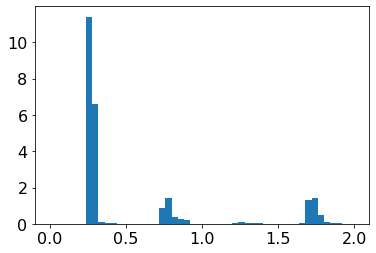

In [12]:
bins = np.linspace(0, 2., 51)
plt.hist(y_crps, bins = bins, density = True)


In [13]:
quantiles
x_in.shape

(12800, 2)

In [14]:
n = x_in.shape[0]

y_pos = []
for i in range(n):
    y_pos.append(qrnn.sample_posterior(x_in[i, :], 1))
y_pos = np.array(y_pos)




In [15]:
y_pos.shape

(12800, 1)

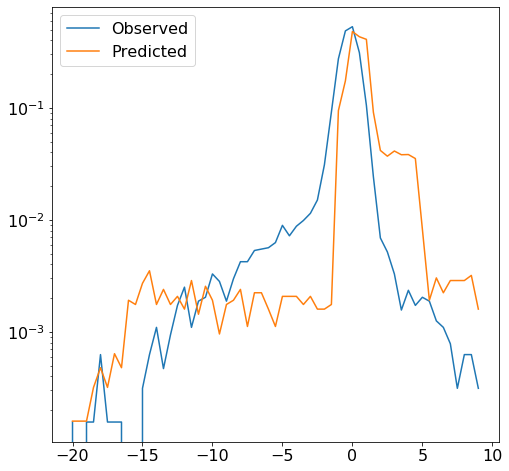

In [16]:
bins = np.arange(-20, 10, 0.5)
fig, ax = plt.subplots(1, 1, figsize = [8, 8])
d0 = y_pre[:, 3] - y
f0, x = np.histogram(d0, bins, density = True)
ax.plot(bins[:-1], f0)
ax.set_yscale('log')

d = []
for i in range(1):
    d.append(y_pos[:, i].ravel() - y_pre[:, 2])

d = np.array(d).ravel()    


f_pos, x = np.histogram(d, bins, density = True)
ax.plot(bins[:-1], f_pos)

#f_prior, x = np.histogram(dtb_prior, bins, density = True)
#ax.plot(bins[:-1], f_prior)

ax.legend(["Observed", "Predicted"])
fig.savefig('Figures/error_distributions')

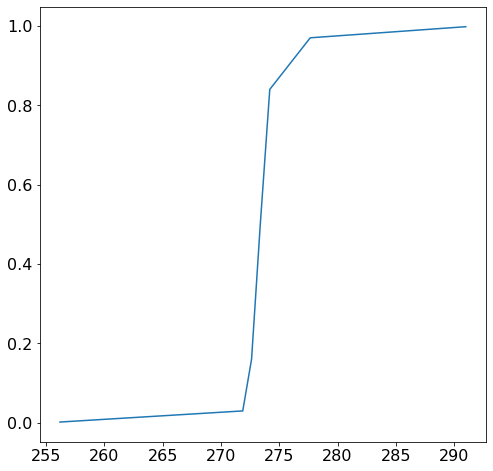

In [17]:
fig, ax = plt.subplots(1, 1, figsize = [8,8])

d = []
j = 12000
for i in range(len(quantiles)):
    d.append(y_pre[:, i])
d = np.array(d)  
d.shape
d = np.mean(d, axis = 1)
ax.plot(d, quantiles)



array([-16.526306  ,  -0.74990845,   0.        ,   0.67852783,
         1.457489  ,   4.9145203 ,  18.370422  ], dtype=float32)

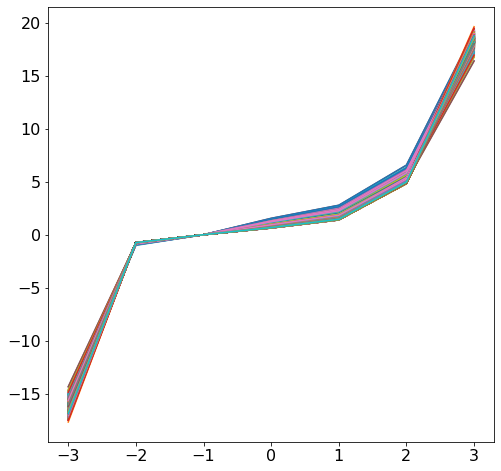

In [18]:
fig, ax = plt.subplots(1, 1, figsize = [8, 8])
x = np.arange(-3, 4, 1)

ind = [10, 130, 16, 190, 17, 140, 500, 1200,2, 45, 67, 78, 5000, 6700]

for i in range(0, 12000, 10):
#for i in ind:
    y1 = y_pre[i,  :] - y_pre[i, 2]
    
    ax.plot(x, y1 )


y_pre[160,  :] - y_pre[160, 2]


-2.9838086e-06 0.99999994


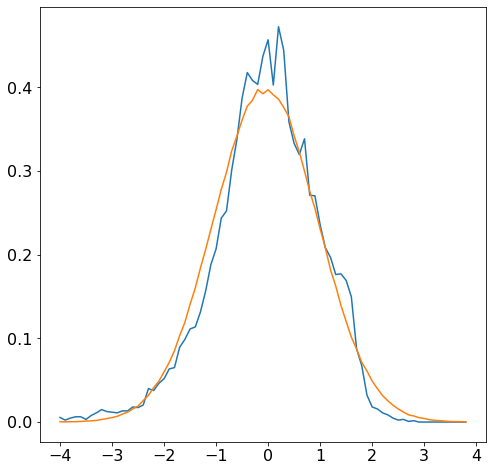

In [19]:
y_all = y_pre[:, 4].ravel()
y_all.shape
bins = np.arange(-4, 4, 0.1)
#plt.hist(y_all, bins)
mean = np.mean(y_all)
std = np.std(y_all)
f, x = np.histogram((y_all - mean)/std, bins, density = True)
fig, ax = plt.subplots(1,1, figsize = [8,8])
ax.plot(bins[:-1], f)

print(np.mean((y_all - mean)/std), np.std((y_all - mean)/std))

y_rand = np.random.normal(0, 1, 1000000)
f, x = np.histogram(y_rand.ravel(), bins, density = True)


ax.plot(bins[:-1], f)
#ax.set_yscale('log')


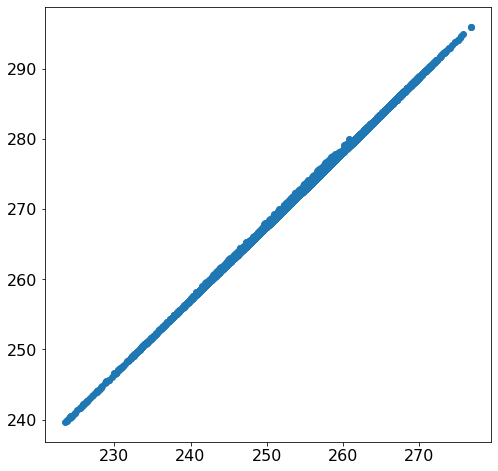

In [20]:
fig, ax = plt.subplots(1, 1, figsize = [8,8])
plt.scatter(y_pre[:, 0], y_pre[:, 4])



NameError: name 'pylab' is not defined

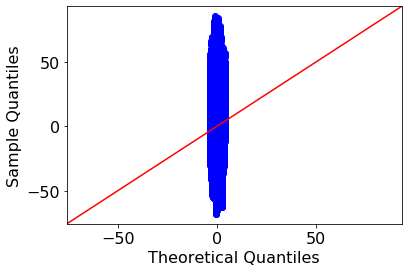

In [21]:
#fig, ax = plt.subplots(1,1, figsize = [8, 8])
for i in [12000]:
    y_rand = np.random.normal(0, 1, 10000)
    y_quant = np.quantile(y_rand, quantiles)
#    ax.plot(y_pre[i, :], y_quant, 'o')
#    ax.plot(y_pre[i , :], y_quant, 'o')
#ax.plot([0,1],[0,1], transform=ax.transAxes)

import statsmodels.api as sm
sm.qqplot(y_pos - y, line='45')
pylab.show()    

In [ ]:
from scipy.stats import gaussian_kde
def density_plot(x, y):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    return x, y, z


In [ ]:
d1 = y_pre[:, 3] - y_pre[:, 1]

dtb_pre = y_pos_mean - y
fig, ax = plt.subplots(1, 2, figsize = [12,8])
fig.tight_layout(pad=3.0)


x, yy, z = density_plot(dtb_pre, d1)
ax[0].scatter(x, yy, c=z, s=50, edgecolor='')

d2 = y_pre[:, 4] - y_pre[:, 0]
x, yy, z = density_plot(dtb_pre, d2)
ax[1].scatter(x, yy, c=z, s=50, edgecolor='')

ax[0].set_ylabel("Uncertainty one-sigma")
ax[1].set_ylabel("Uncertainty two-sigma")

ax[0].set_xlabel("Observed errors")
ax[1].set_xlabel("Observed errors")

imm = d1 > 0.54


In [ ]:
binstep = 0.5
bins = np.arange(-30, 5, binstep)
fig, ax = plt.subplots(1, 1, figsize = [8, 8])
h = np.histogram(dtb_pre[imm], bins, density = True)
ax.plot(bins[:-1], h[0])
ax.plot(bins[:-1], hist_pre[0])
ax.plot(bins[:-1], hist_pos_mean[0])
ax.set_yscale("log")
ax.legend(["uncertainity", "predicted", "posterior_mean"])

In [ ]:
def get_conf_interval(y_pre,y_true):

    iq1 = 1
    iq2 = 3
    conf_interval_length = []
    in_interval = []
    
    confidence_interval = y_pre[:, iq2] - y_pre[:, iq1]

    for i in range(y_true.shape[0]):
        interval_start = y_pre[:, iq1]
        interval_end   = y_pre[:, iq2]
        
        if (y_true[i] >= interval_start, y_true[i] <= interval_end):
            in_interval.append(1)
        else:
            in_interval.append(0)
    
    frac_correct = np.sum(in_interval) / len(y_pre)
    return confidence_interval, in_interval, frac_correct

In [ ]:
conf_intervals, in_interval, frac_correct = get_conf_interval(y_pre, y_pre[:, 3])
fig, ax = plt.subplots(1,1 , figsize  = [10, 6])
bins = np.arange(0.50, 0.70, 0.001)
hist = np.histogram(conf_intervals, bins, density = True)
plt.plot(bins[:-1], hist[0])


min_len = 0.5
max_len = 0.7
n_bins = 600

plt.figure(figsize=(15,8))
bins_all = np.linspace(min_len,max_len,n_bins)
#n_1,x_1,_ = plt.hist(conf_ints_1,bins=bins_all, normed=True);
n_2,x_2,_ = plt.hist(conf_intervals,bins=bins_all, density=True)
plt.plot(x_2[:-1], n_2)

In [ ]:
def get_correct_by_bins(conf_ints, label_in_int,top_bound):
    interval_size  = 0.01

    lower_bounds = np.arange(conf_ints.min() , conf_ints.max(), interval_size)
    upper_bounds = lower_bounds + interval_size
    bound_mids = (lower_bounds + upper_bounds) / 2

    corr_sum = []

    for k in range(0, len(lower_bounds)):
        low_bound = lower_bounds[k]
        up_bound = upper_bounds[k]
        
        conf_inds = np.where(np.logical_and(conf_ints > low_bound, conf_ints < up_bound))[0]

#        print (conf_inds, low_bound, up_bound)
        
        corr_sum.append(len(conf_inds))

        
    return np.array(corr_sum)/len(conf_ints), bound_mids, upper_bounds

In [ ]:
fractions_of_correct, bound_mids, upper_bounds = get_correct_by_bins(conf_intervals, in_interval, 0.70)
fig, ax = plt.subplots(1, 1, figsize = [8, 15])
ax.plot(bound_mids, fractions_of_correct, marker = 'o', color = 'C0')

In [ ]:
nn_width_all = [8, 16, 32, 64, 128, 256, 512]
scores = np.empty([3, 7])
loss = np.empty([3, 7])
for i, nn_depth in enumerate([2, 3, 4]):
    for j, nn_width in enumerate(nn_width_all):
        filename = "option4_qrnn_models//qrnn_%s_%s_%s.nc" % (str(nn_depth), str(nn_width), str(inChannels[0]))
        qrnn = QRNN.load(filename)
        
        y_pre = []
        y = []
        y_prior = []
        y_pos_mean = []

        nbatch = validation_data.__len__()
        for ii in range(nbatch):

            xx, yy = validation_data.__getitem__(ii)

            x = xx.detach().numpy() 

            y_prior.append((x * data.std) + data.mean)
        #    y_prior.append((x[:, 0]))

            y_pre.append(qrnn.predict(x)) 
            y_pos_mean.append((qrnn.posterior_mean(x)))

            y.append(yy.detach().numpy())
            
        y_pre = np.concatenate(y_pre, axis = 0)
        y = np.concatenate(y, axis= 0)
        y_prior = np.concatenate(y_prior, axis = 0)
        y_pos_mean = np.concatenate(y_pos_mean, axis = 0)    

        scores[i,j] = np.mean(qrnn.crps(y_pre, y, quantiles))
    
        loss[i,j] = quantile_loss(y_pre, y, quantiles)

In [ ]:
def quantile_loss(y_pre, y, quantiles):
    loss = 0
    for i in range(len(quantiles)):
        dy = y_pre[:, i] - y
        qs = quantiles[i]
        l = np.where(dy >= 0.0, 
                        (1.0 - qs) * abs(dy),
                        (qs) * abs(dy))
        loss += l.mean()
    return loss.mean()  

In [ ]:
fig, ax = plt.subplots(1,1, figsize = [8,8])
for i in range(3):
    ax.plot(scores[i, :])
ax.set_xlabel("Layer Width")
ax.set_ylabel("CRPS")
ax.set_xticks(np.arange(len(nn_width_all)))
ax.set_xticklabels(nn_width_all)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.4)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = [8,8])
for i in range(3):
    ax.plot(loss[i, :])
ax.set_xlabel("Layer Width")
ax.set_ylabel("quantile_loss")
ax.set_xticks(np.arange(len(nn_width_all)))
ax.set_xticklabels(nn_width_all)
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.grid(which = 'both', alpha = 0.4)
ax.legend([2, 3, 4])

In [ ]:

import math
def step_decay(epoch, lr):
    # initial_lrate = 1.0 # no longer needed
    drop = 0.5
    epochs_drop = 2.0
    lrate = lr * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

In [ ]:
step_decay(20, 0.01)